<a href="https://colab.research.google.com/github/CarolineP-DS/pyCOVID-demo/blob/master/notebooks/Iteration2_Finale_DN201_Unfreezed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 4 : Modelisation Iteration 2

## Google Colab: import data & check GPU activation

1. Data folder has been uploaded to Google Drive. Leaving it there increases x30 computing time : we need to extract it to the local Colab disk.
1. Google Colab enables GPU acceleration. It needs to be switched on in the `Runtime > Change Runtime type` menu. We check if GPU is activated and detectable. Output should be something like `"Found GPU at: /device:GPU:0"`. If `"GPU device not found"`, then GPU is not enabled.

In [ ]:
### If "data" folder doesn't exist, then mount GDrive, extract data and unmount GDrive

import os
if os.path.isdir('./data'):
  print("Data is already on local disk, skipping importing step.")

else:
  ## Mount and access Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  ## Unzip pyCOVID_data.7z to local Colab disk
  !7z x "./gdrive/My Drive/pyCOVID/pyCOVID_data.7z"

Data is already on local disk, skipping importing step.


In [ ]:
### Check if GPU is being used
## print output should say : "Found GPU at: /device:GPU:0"
# if "GPU device not found", go to Runtime > Change Runtime type & select GPU

%tensorflow_version 2.x
import tensorflow as tf
gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_name))

Found GPU at: /device:GPU:0


## Importing librairies

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils 
from keras.metrics import Recall

from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201

from sklearn import metrics
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt
from matplotlib import cm

# set timezone
import time
os.environ['TZ'] = 'Europe/Paris'
time.tzset()

### Custom matplotlib Colab dark theme Caro
plt.rcParams.update({
    "figure.figsize": [6,4.5],
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "#CDD2E9",
    "axes.facecolor": "#383838",
    "axes.edgecolor": "#899ab8",      
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#546379",
    "figure.facecolor": "#383838",
    "figure.edgecolor": "#899ab8",
    "savefig.facecolor": "#383838",
    "savefig.edgecolor": "#899ab8"})

## Create a dataframe with filepaths and classes

Since the metadata files were missing a file for the COVID type, we re-listed ourselves the files contained in each of the three folders and assigned labels and class numbers accordingly.

The three classes were one-hot encoded in order to not use the `sparse_categorical_crossentropy` loss function but the `categorical_crossentropy` and thus be able to use binary metrics such as Precision or Recall.

In [ ]:
#### Get all filepaths and corresponding folder==class
import os.path
from natsort import natsorted

# data root folder
# datapath = "data/"    # Caro local
# datapath = "/content/gdrive/My Drive/pyCOVID/data/"   # Google Colab mounted Google Drive
datapath = "./data/"    # Google Colab local

types = ["Viral Pneumonia", "NORMAL", "COVID"]
files = []       # filepaths of all image for each folder/type

for t in types:
    # list of filepaths in each folder/type
    files.append([datapath + t + "/" + f for f in os.listdir(datapath + t + "/")if os.path.isfile(os.path.join(datapath + t + "/", f))])
    
# flatten the list of 3 sublists
files = [item for sublist in files for item in sublist]

# turn into a naturally sorted DF
df = pd.DataFrame(natsorted(files), columns=["filepaths"])

# add labels
df["label"] = np.where(df.filepaths.str.contains("Viral Pneumonia"), "ViralPneumonia",
                       np.where(df.filepaths.str.contains("NORMAL"), "Normal", "COVID"))

onehot = pd.get_dummies(df["label"])

df = pd.concat([df, onehot], axis=1)

df["class"] = np.where(df.filepaths.str.contains("Viral Pneumonia"), "2",
                       np.where(df.filepaths.str.contains("NORMAL"), "0", "1"))

df = df[["filepaths", "label", "class", "Normal", "COVID", "ViralPneumonia"]]

print("Number of files per type:")
print(df["label"].value_counts())
print("\nLabels and classes:")
print("Normal\t\t= 0\nCOVID\t\t= 1\nViral Pneumonia\t= 2")

df.head(10)

Number of files per type:
ViralPneumonia    1345
Normal            1341
COVID             1200
Name: label, dtype: int64

Labels and classes:
Normal		= 0
COVID		= 1
Viral Pneumonia	= 2


,filepaths,label,class,Normal,COVID,ViralPneumonia
0,./data/COVID/COVID (1).png,COVID,1,0,1,0
1,./data/COVID/COVID (2).png,COVID,1,0,1,0
2,./data/COVID/COVID (3).png,COVID,1,0,1,0
3,./data/COVID/COVID (4).png,COVID,1,0,1,0
4,./data/COVID/COVID (5).png,COVID,1,0,1,0
5,./data/COVID/COVID (6).png,COVID,1,0,1,0
6,./data/COVID/COVID (7).png,COVID,1,0,1,0
7,./data/COVID/COVID (8).png,COVID,1,0,1,0
8,./data/COVID/COVID (9).png,COVID,1,0,1,0
9,./data/COVID/COVID (10).png,COVID,1,0,1,0


## Split data: training / test
We split the data with the training set representing 80% of the complete dataset, and the testing set representing the remaining 20%. The split is stratified, to preserve the proportions of classes in both sets.

In [ ]:
data_train, data_test = train_test_split(df, 
                                         test_size=0.2, 
                                         stratify=df["class"], 
                                         random_state=123)

print(data_train.shape, data_test.shape)

(3108, 6) (778, 6)


## Image generator

We'll be implementing several transformations on the training dataset :

* rotation
* horizontal/vertical shift
* horizontal/vertical flip

In [ ]:
### Image generator
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range=10,
                                          width_shift_range=.1,
                                          height_shift_range=.1,
                                          # zoom_range=.1,
                                          # brightness_range=[0.2,1.0],
                                          horizontal_flip=True,
                                          vertical_flip=True)

test_data_generator = ImageDataGenerator(rescale = 1./255)

### Iterator
batch_size = 32
n_class = len(df["class"].unique())

# pour éviter l'erreur If class_mode="sparse", y_col="class" column values must be strings.
# il faut convertir data["class"] en str()

pd.options.mode.chained_assignment = None   # suppress Pandas SettingWithCopyWarning
data_train["class"] = data_train["class"].astype(str)
data_test["class"] = data_test["class"].astype(str)
pd.options.mode.chained_assignment = "warn"   # set default back

training_set = train_data_generator.flow_from_dataframe(dataframe=data_train,      # df contenant les infos
                                                        x_col="filepaths",         # col du df contenant les filepaths
                                                        y_col=["Normal", "COVID", "ViralPneumonia"],             # cols du df contenant les one hot encoded classes
                                                        class_mode="raw",       # pour prendre les 4 colonnes
                                                        target_size=(224,224),     # taille des images à redimensionner
                                                         color_mode="rgb",      # images en couleurs                                                       
                                                        batch_size=batch_size)

test_set = test_data_generator.flow_from_dataframe(dataframe=data_test,         # df contenant les infos
                                                   x_col="filepaths",           # col du df contenant les filepaths
                                                   y_col=["Normal", "COVID", "ViralPneumonia"],             # cols du df contenant les one hot encoded classes
                                                   class_mode="raw",         # pour prendre les 4 colonnes
                                                   target_size=(224,224),       # taille des images à redimensionner
                                                   color_mode="rgb",            # images en couleurs
                                                   shuffle = False,             # nécessaire pour que les prédictions soient dans le même ordre que les vraies valeurs
                                                   batch_size=batch_size)

Found 3108 validated image filenames.
Found 778 validated image filenames.


## Network design

We use the DenseNet121 model<sup>1, 2</sup> with its weights set to the `imagenet` dataset and without the fully connected layers (`include_top = False`).

<br>

---

1: Densely Connected Convolutional Networks, Huang _et al._, 2018, [arXiv](https://arxiv.org/pdf/1608.06993.pdf)

2: https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a


In [ ]:
model=DenseNet201(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 

model_output = model.output

model_output = GlobalAveragePooling2D()(model_output)
model_output = BatchNormalization()(model_output)
model_output = Dropout(rate = 0.2)(model_output)
model_output = Dense(units = 1024, activation = 'relu')(model_output) 
model_output = Dense(units = 512, activation = 'relu')(model_output) 
model_output = BatchNormalization()(model_output)
model_output = Dropout(rate = 0.2)(model_output)

preds = Dense(units = n_class, activation = 'softmax')(model_output) # FC-layer

model = Model(inputs = model.input, outputs = preds)

dense_layers = 8    # number of dense layers
last_block = 9      # number of layers in block 32 (last CNN block)
layers_to_unfreeze = dense_layers + last_block

# Freezing DenseNet201 layers' weights
for layer in model.layers[:-layers_to_unfreeze]:
    layer.trainable=False
    
for layer in model.layers[-layers_to_unfreeze:]:
    layer.trainable=True

model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

### Compilation

Adding recall metrics for each **class**.

In [ ]:
## compilation
model.compile(optimizer = "adam", 
                   loss = "categorical_crossentropy",                   
                   metrics = ["accuracy", 
                              Recall(class_id=0, name="recall_norm"),
                              Recall(class_id=1, name="recall_COV"),
                              Recall(class_id=2, name="recall_VP")])

### Callbacks

Adding callbacks:

* ReduceLROnPlateau: based on `val_loss`
* EarlyStopping: based on `val_loss`
* ModelCheckpoint: based on `val_loss`

In [ ]:
## callbacks
# early stopping : stopper l'entraînement lorsque val_loss est minimisé
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10, 
                                        mode="min", 
                                        restore_best_weights=True)

# save best model (with minimum val_loss)
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
filepath = 'best_DenseNet201_Unfreezed' + timestr + '.h5'

checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# reduce learning rate when reaching val_loss plateau (default factor = 0.1)
lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience = 3, verbose = 2, mode = "min")

### Fitting

We fit over 50 epochs.

In [ ]:
epochs = 50

## fitting
training_history = model.fit(training_set,
                             epochs=epochs, 
                             steps_per_epoch=len(training_set._filepaths) // batch_size,
                             workers = -1, 
                             validation_data=test_set, 
                             validation_steps=len(test_set._filepaths) // batch_size,
                             callbacks = [early_stopping_callback, lr_plateau, checkpoint_callback],
                             verbose=1)

Epoch 1/50
97/97 [==============================] - 106s 915ms/step - loss: 0.4171 - accuracy: 0.8808 - recall_norm: 0.8615 - recall_COV: 0.9317 - recall_VP: 0.8389 - val_loss: 0.1791 - val_accuracy: 0.9297 - val_recall_norm: 0.9735 - val_recall_COV: 0.9456 - val_recall_VP: 0.8717

Epoch 00001: val_loss improved from inf to 0.17914, saving model to best_DenseNet201_Unfreezed2021-02-23_18-23-58.h5
Epoch 2/50
97/97 [==============================] - 85s 879ms/step - loss: 0.1391 - accuracy: 0.9502 - recall_norm: 0.9468 - recall_COV: 0.9766 - recall_VP: 0.9246 - val_loss: 0.1608 - val_accuracy: 0.9440 - val_recall_norm: 0.9886 - val_recall_COV: 0.9791 - val_recall_VP: 0.8642

Epoch 00002: val_loss improved from 0.17914 to 0.16077, saving model to best_DenseNet201_Unfreezed2021-02-23_18-23-58.h5
Epoch 3/50
97/97 [==============================] - 85s 878ms/step - loss: 0.1705 - accuracy: 0.9434 - recall_norm: 0.9200 - recall_COV: 0.9796 - recall_VP: 0.9326 - val_loss: 0.1228 - val_accuracy

The best saved model was at epoch 9


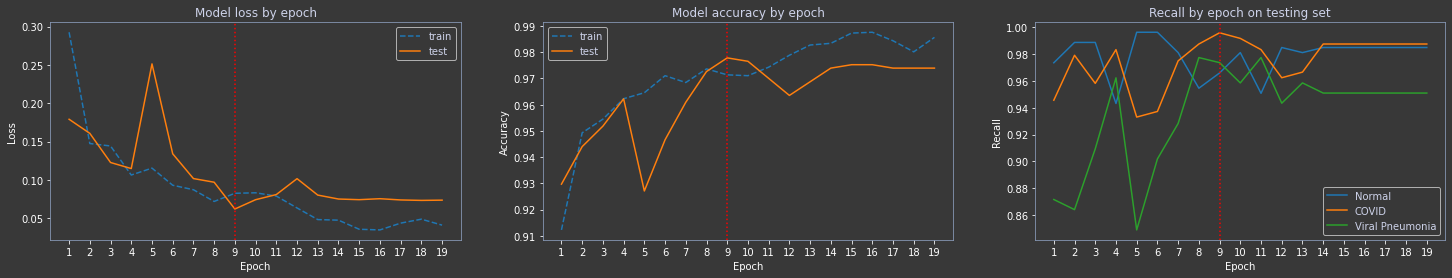

In [ ]:
n_epochs = len(training_history.history["val_loss"])        # total of epochs before early stopping
n_epochs_best = np.argmin(training_history.history['val_loss'])    # best epoch based on val_loss (early_stopping), starting at epoch 1 (not 0)
print("The best saved model was at epoch", n_epochs_best + 1)

plt.figure(figsize=(25,4))
plt.subplot(131)
plt.plot(training_history.history['loss'], "--")
plt.plot(training_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(132)
plt.plot(training_history.history['accuracy'], "--")
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(133)
plt.plot(training_history.history['val_recall_norm'], label="Normal")
plt.plot(training_history.history['val_recall_COV'], label="COVID")
plt.plot(training_history.history['val_recall_VP'], label="Viral Pneumonia")
plt.title('Recall by epoch on testing set')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend();

## Model evaluation

We evaluate the model based on recall.

In [ ]:
# evaluate the model
train_loss, train_acc, train_recall_norm, train_recall_COV, train_recall_VP = model.evaluate(training_set, verbose=0)
test_loss, test_acc, test_recall_norm, test_recall_COV, test_recall_VP = model.evaluate(test_set, verbose=0)

In [ ]:
print('Train accuracy: %.2f%%,\t\t\tTest accuracy: %.2f%%' % (train_acc*100, test_acc*100))
print('Train recall Normal: %.2f%%,\t\tTest recall Normal: %.2f%%' % (train_recall_norm*100, test_recall_norm*100))
print('Train recall COVID: %.2f%%,\t\tTest recall COVID: %.2f%%' % (train_recall_COV*100, test_recall_COV*100))
print('Train recall Viral Pneumonia: %.2f%%,\tTest recall Viral Pneumonia: %.2f%%' % (train_recall_VP*100, test_recall_VP*100))

Train accuracy: 98.13%,			Test accuracy: 97.81%
Train recall Normal: 97.67%,		Test recall Normal: 96.65%
Train recall COVID: 99.90%,		Test recall COVID: 99.58%
Train recall Viral Pneumonia: 96.93%,	Test recall Viral Pneumonia: 97.40%


In [ ]:
# Prediction de l'échantillon de test
test_pred = model.predict(test_set)

# repasser en labels de classes
y_test_class = np.array(data_test['class'].astype(int))
test_pred_class = test_pred.argmax(axis=1)

                 precision    recall  f1-score   support

         Normal       0.97      0.97      0.97       269
          COVID       1.00      1.00      1.00       240
Viral Pneumonia       0.96      0.97      0.97       269

       accuracy                           0.98       778
      macro avg       0.98      0.98      0.98       778
   weighted avg       0.98      0.98      0.98       778



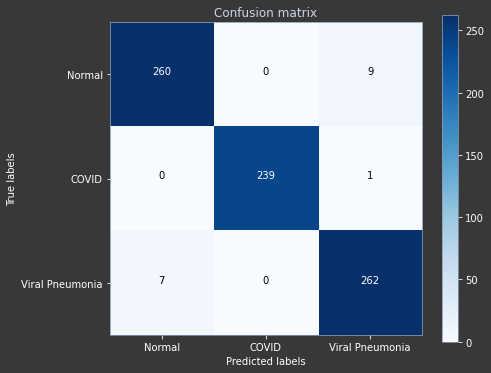

In [ ]:
### matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

classes = range(0,n_class)
labels_class = ["Normal", "COVID", "Viral Pneumonia"]

plt.figure(figsize = (7,6))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');

print(metrics.classification_report(y_test_class, test_pred_class, target_names=labels_class))

                 precision    recall  f1-score   support

         Normal       0.97      0.97      0.97       269
          COVID       1.00      1.00      1.00       240
Viral Pneumonia       0.96      0.97      0.97       269

       accuracy                           0.98       778
      macro avg       0.98      0.98      0.98       778
   weighted avg       0.98      0.98      0.98       778



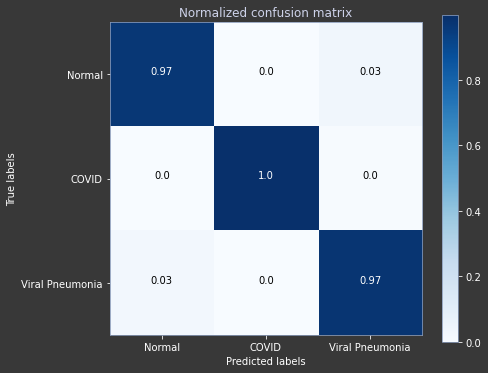

In [ ]:
### matrice de confusion normalisée
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class, normalize="true")

classes = range(0,n_class)
labels_class = ["Normal", "COVID", "Viral Pneumonia"]

plt.figure(figsize = (7,6))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Normalized confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');

print(metrics.classification_report(y_test_class, test_pred_class, target_names=labels_class))

# Save model to Google Drive

In [ ]:
### Save full model to Google Drive

# find file ending with .h5
for file in os.listdir("."):
    if file.endswith(".h5"):
        h5_path = os.path.join("/content/", file)
        model_name = file

# copy from Colab to Drive
!cp {h5_path} "./gdrive/My Drive/pyCOVID/model/{model_name}"